# Basic use of Round Robin on Titanic

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

from typing import Dict, List, Set
from mdrsl.data_structures.rules.multi_target_class_association_rule import MCAR
from mdrsl.evaluation.predictive_performance_metrics import ScoreInfo
from mdrsl.rule_models.mids.mids_rule import MIDSRule
from mdrsl.rule_generation.association_rule_mining.mlext_impl.mlext_interaction import mine_MCARs_mlext
from mdrsl.rule_models.rr.io_rr_rule_set_learner import store_greedy_naive_classifier, load_greedy_naive_classifier
from mdrsl.rule_models.rr.scoring import score_mt_clf_on_its_targets_without_nans

import matplotlib.pyplot as plt
import seaborn as sns

TargetAttr = str
RuleSetScore = float

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Titanic toy dataset

In [3]:
from mdrsl.project_info import project_dir
from mdrsl.toy_data.titanic import prepare_data_titanic

data_dir = os.path.join(project_dir, 'data/external')

df_train: pd.DataFrame
df_test: pd.DataFrame
df_train, df_test, dataset_name = prepare_data_titanic(data_dir, prop=0.25)
df_train.head()

,Passenger_Cat,Age_Cat,Gender,Survived
0,3rd_class,adult,male,0
1,crew,adult,male,0
2,3rd_class,adult,female,0
3,crew,adult,male,0
4,crew,adult,male,0


In [4]:
cols: np.ndarray = df_train.columns.values
cols

array(['Passenger_Cat', 'Age_Cat', 'Gender', 'Survived'], dtype=object)

## Mining multi-target association rules

In [5]:
min_support = 0.01
min_confidence = 0.5
rule_cutoff = 150

cars: List[MCAR]
time_info: Dict[str, float]

cars, time_info = mine_MCARs_mlext(df_train, min_support=min_support, min_confidence=min_confidence)
if len(cars) > rule_cutoff:
    cars = cars[:rule_cutoff]

In [6]:
from mdrsl.data_structures.rules.pretty_printing import mids_mcar_to_pretty_string
for rule in cars:
    print(mids_mcar_to_pretty_string(rule))

Gender=male -> Age_Cat=adult
Age_Cat=adult -> Gender=male
Survived=0 -> Age_Cat=adult
Age_Cat=adult -> Survived=0
Survived=0 -> Gender=male
Gender=male -> Survived=0
Gender=male, Survived=0 -> Age_Cat=adult
Age_Cat=adult, Survived=0 -> Gender=male
Age_Cat=adult, Gender=male -> Survived=0
Survived=0 -> Age_Cat=adult, Gender=male
Gender=male -> Age_Cat=adult, Survived=0
Age_Cat=adult -> Gender=male, Survived=0
Passenger_Cat=3rd_class -> Age_Cat=adult
Passenger_Cat=3rd_class -> Survived=0
Passenger_Cat=3rd_class -> Gender=male
Passenger_Cat=3rd_class, Survived=0 -> Age_Cat=adult
Age_Cat=adult, Passenger_Cat=3rd_class -> Survived=0
Passenger_Cat=3rd_class -> Age_Cat=adult, Survived=0
Gender=male, Passenger_Cat=3rd_class -> Age_Cat=adult
Age_Cat=adult, Passenger_Cat=3rd_class -> Gender=male
Passenger_Cat=3rd_class -> Age_Cat=adult, Gender=male
Passenger_Cat=3rd_class, Survived=0 -> Gender=male
Gender=male, Passenger_Cat=3rd_class -> Survived=0
Passenger_Cat=3rd_class -> Gender=male, Survive

## Fitting a Round Robin model

In [7]:
mids_rules = list(map(MIDSRule, cars))

In [8]:
from mdrsl.rule_models.rr.rr_rule_set_learner import GreedyRoundRobinTargetRuleClassifier

clf = GreedyRoundRobinTargetRuleClassifier(df_train.columns,verbose=True, keep_score_evolution=True)

selected_set: Set[MIDSRule]
selected_set_scores: Dict[TargetAttr, RuleSetScore]
selected_set, selected_set_scores = clf.fit(df_train, mids_rules)

/home/joschout/Documents/Repos/MULES/Multi-Directional_Rule_Set_Learning/mdrsl/data_handling/type_checking_dataframe.py:14: UserWarning: Removed QuantitiveDataFrame type check, might need to be included again
  warnings.warn("Removed QuantitiveDataFrame type check, might need to be included again")
/home/joschout/Documents/Repos/MULES/Multi-Directional_Rule_Set_Learning/mdrsl/data_handling/type_checking_dataframe.py:28: UserWarning: All columns of a dataframe should be string types.
The following columns are not stringly typed:
	Survived: int64 Maybe you did not discretize all numerical attributes?
CONVERTED THESE COLUMNS TO STRING!
  warnings.warn(
/home/joschout/Documents/Repos/MULES/Multi-Directional_Rule_Set_Learning/mdrsl/rule_models/multi_target_rule_set_clf_utils/default_classes.py:23: UserWarning: multiple modes found for some attributes in the training data; 
  Passenger_Cat Age_Cat Gender Survived
0          crew   adult   male        0
  warnings.warn("multiple modes found f

Calculating init score for Passenger_Cat...
Calculating init score for Age_Cat...
Calculating init score for Gender...
Calculating init score for Survived...
=== start rule Learning ===
Initial target scores (empty set): {'Passenger_Cat': 0.38455715367146104, 'Age_Cat': 0.9500378501135504, 'Gender': 0.7774413323239969, 'Survived': 0.6691900075700227}
It 1 - target: Age_Cat  (1/4)
Found no improvement for Age_Cat
It 1 - target: Gender  (2/4)
for target Gender, 4 rules lead to an improved prediction
best rule results in score 0.813777441332324
4 rules are being considered as best...
	considering score for Age_Cat: 0.0
for target Gender, best rule least hurting others results in score 0.8138 (improvement of 0.0363)
resetting improvement found flags for Gender ...
End it. 2
-------------------------
It 2 - target: Survived  (1/4)
for target Survived, 11 rules lead to an improved prediction
best rule results in score 0.7751703255109765
11 rules are being considered as best...
	considering s

## Inspecting the fitted model

In [9]:
print("Rule set scores:")
print(selected_set_scores)
print()
print("Defaults:")
print(clf.default_predictions)
print()
print("Rules: ")
for rule in selected_set:
    print(rule)

Rule set scores:
{'Passenger_Cat': 0.4647993943981832, 'Age_Cat': 0.9500378501135504, 'Gender': 0.8455715367146103, 'Survived': 0.7751703255109765}

Defaults:
{'Passenger_Cat': 'crew', 'Age_Cat': 'adult', 'Gender': 'male', 'Survived': '0'}

Rules: 
MIDS-MCAR {Age_Cat=child} => {Passenger_Cat=3rd_class} sup: 0.04 conf: 0.74 len: 2, id: 71 f1: 0.0706560922855083
MIDS-MCAR {Gender=female} => {Survived=1} sup: 0.16 conf: 0.74 len: 2, id: 54 f1: 0.26873065015479874
MIDS-MCAR {Survived=1,Passenger_Cat=2nd_class} => {Gender=female} sup: 0.04 conf: 0.78 len: 3, id: 146 f1: 0.0831541218637993
MIDS-MCAR {Survived=0,Gender=female} => {Passenger_Cat=3rd_class} sup: 0.05 conf: 0.90 len: 3, id: 59 f1: 0.09871244635193131
MIDS-MCAR {Survived=1,Passenger_Cat=1st_class,Age_Cat=adult} => {Gender=female} sup: 0.06 conf: 0.70 len: 4, id: 110 f1: 0.11781011781011781


/home/joschout/Documents/Repos/MULES/Multi-Directional_Rule_Set_Learning/mdrsl/rule_models/mids/mids_rule.py:26: UserWarning: possibly not correct for multi-target prediction
  warnings.warn("possibly not correct for multi-target prediction")


In [10]:
greedy_clf_rules = clf.learned_rule_set
max_len: int = max([len(mids_mcar_to_pretty_string(mids_rule.car)) for mids_rule in greedy_clf_rules])
greedy_rule_strs = []
for mids_rule in clf.learned_rule_set:
    greedy_rule_strs.append(mids_mcar_to_pretty_string(mids_rule.car).ljust(max_len)
          + "\t" + f"s: {mids_rule.car.support:0.3f}, c: {mids_rule.car.confidence:0.3f}"
          )
greedy_rule_strs.sort()
for s in greedy_rule_strs:
    print(s)
print("Defaults", clf.default_predictions)
print("---")


Age_Cat=adult, Passenger_Cat=1st_class, Survived=1 -> Gender=female	s: 0.064, c: 0.697
Age_Cat=child -> Passenger_Cat=3rd_class                           	s: 0.037, c: 0.742
Gender=female -> Survived=1                                        	s: 0.164, c: 0.738
Gender=female, Survived=0 -> Passenger_Cat=3rd_class               	s: 0.052, c: 0.896
Passenger_Cat=2nd_class, Survived=1 -> Gender=female               	s: 0.044, c: 0.784
Defaults {'Passenger_Cat': 'crew', 'Age_Cat': 'adult', 'Gender': 'male', 'Survived': '0'}
---


In [11]:
clf.default_predictions

{'Passenger_Cat': 'crew',
 'Age_Cat': 'adult',
 'Gender': 'male',
 'Survived': '0'}

In [12]:
target_to_score_info: Dict[TargetAttr, ScoreInfo] = score_mt_clf_on_its_targets_without_nans(
    clf, df_test, filter_nans=True)

/home/joschout/Documents/Repos/MULES/Multi-Directional_Rule_Set_Learning/mdrsl/data_handling/type_checking_dataframe.py:28: UserWarning: All columns of a dataframe should be string types.
The following columns are not stringly typed:
	Survived: int64 Maybe you did not discretize all numerical attributes?
CONVERTED THESE COLUMNS TO STRING!
  warnings.warn(


In [13]:
for target, val in target_to_score_info.items():
    print(target)
    print(val.to_str("\t"))

Passenger_Cat
	acc: 0.5204545454545455
	balanced acc: 0.30905613183256087
	micro averaged f1: 0.5204545454545455

Age_Cat
	acc: 0.9431818181818182
	balanced acc: 0.5
	micro averaged f1: 0.9431818181818182

Gender
	acc: 0.8522727272727273
	balanced acc: 0.7095689628458988
	micro averaged f1: 0.8522727272727273

Survived
	acc: 0.75
	balanced acc: 0.6715371127995324
	micro averaged f1: 0.75



### Visualization of the F1-score evolution during the fitting of the model

In [14]:
df_score_evolution = clf.score_evolution_to_dataframe()
df_score_evolution.head()

,time_point,target_attribute,score_value
0,0,Passenger_Cat,0.384557
1,1,Passenger_Cat,0.384557
2,2,Passenger_Cat,0.384557
3,3,Passenger_Cat,0.436033
4,4,Passenger_Cat,0.436033


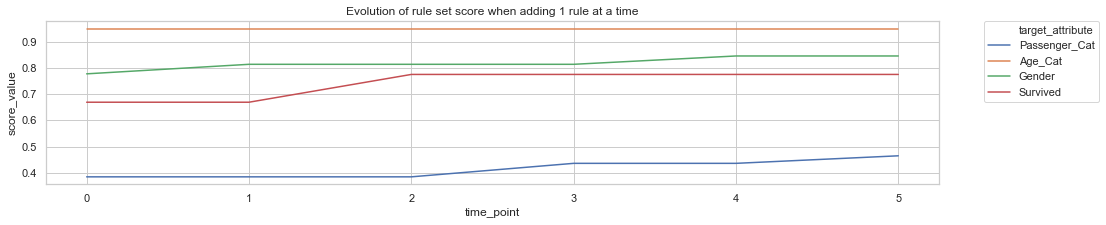

In [15]:
sns.set(style="whitegrid")

width = 16
height = 3
figsize = (width, height)
fig, axes = plt.subplots(figsize=figsize)
ax = sns.lineplot(x='time_point',
           y='score_value',
           data=df_score_evolution,
           hue='target_attribute'
           )
ax.set_title(f"Evolution of rule set score when adding 1 rule at a time")
# ax3.tight_layout(rect=[0, 0.03, 1, 0.95]) # make sure the subplots don't overlap
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
